## MAPK model testing notebook
*Nathaniel Linden - September 2023*

We will use this notebook to test each of the MAPK models by attempting to recreate a figure from their original papers

In [1]:
import numpy as np
import diffrax
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import equinox as eqx
import sys
from scipy.stats import mode

sys.path.append("./models/")
from huang_ferrell_1996 import *
from bhalla_iyengar_1999 import *
from kholodenko_2000 import *
from levchenko_2000 import *
from brightman_fell_2000 import *
from schoeberl_2002 import *
from hatakeyama_2003 import *
from hornberg_2005 import *
from birtwistle_2007 import *
from orton_2009 import *
from vonKriegsheim_2009 import *
from shin_2014 import *
from ryu_2015 import *
from kochanczyk_2017 import *
from dessauges_2022 import *


jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('~/.matplotlib/custom.mplstyle')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
from plotting_helper_funcs import *


## Helper functions
First we define a few help functions that will be used throughout the notebook.
They functions simulate a trajectory, and a steady-state.

In [2]:
def simulate_model_trajectory(model_instance, y0, params, t1=300, dt0=1e-3, n_out=1000):
    """ simulates a model over the specified time interval and returns the 
    trajectory of the model state variables."""
    ode_term = diffrax.ODETerm(model_instance)
    solver = diffrax.Kvaerno5()
    stepsize_controller = diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    dt0 = 1e-3
    times = np.linspace(t0, t1, n_out)
    saveat = saveat=diffrax.SaveAt(ts=times)

    sol = diffrax.diffeqsolve(
        ode_term, 
        solver, 
        t0, t1, dt0, 
        y0, 
        saveat=saveat, stepsize_controller=stepsize_controller,
        args=tuple(params),
        max_steps=60000,
        throw=False,)
    
    return sol

def simulate_model_steady_state(model_instance, y0, params, t1=300, dt0=1e-3, 
    event_rtol=1e-6, event_atol=1e-6):
    """ simulates a model over the specified time interval and returns the 
    calculated steady-state values."""
    ode_term = diffrax.ODETerm(model_instance)
    solver = diffrax.Kvaerno5()
    event=diffrax.SteadyStateEvent(event_rtol, event_atol)
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    dt0 = 1e-3

    sol = diffrax.diffeqsolve(
        ode_term, 
        solver, 
        t0, t1, dt0, 
        y0, 
        stepsize_controller=stepsize_controller,
        discrete_terminating_event=event,
        args=tuple(params),
        max_steps=None,
        throw=True,)
    
    return sol


## Huang and Ferrell 1996
We want to recreate Figure 2B from the paper that overlays the stimulus response curve for the three main kinases. The following cells run the simulations and create the figure.

In [ ]:
# load data from the paper
HF_1996_fig2_B_MAPK = pd.read_csv('./paper_data/HF_1996_fig2B_MAPK.csv').to_numpy()
# HF_1996_fig2_B_MAPK = np.vstack((HF_1996_fig2_B_MAPK, np.array([HF_1996_fig2_B_MAPK[-1, 0]*100, np.nan])))
HF_1996_fig2_B_MAPKK = pd.read_csv('./paper_data/HF_1996_fig2B_MAPKK.csv').to_numpy()
HF_1996_fig2_B_MAPKKK = pd.read_csv('./paper_data/HF_1996_fig2B_MAPKKK.csv').to_numpy()

# run series of simulations to generate steady-state data in the figure
hf_1996 = huang_ferrell_1996()
_, y0 = hf_1996.get_initial_conditions()
ss = []
E1_vals = np.logspace(-5.75, -1, 700)
for i, E1 in enumerate(E1_vals):
    # update params with new stimulus
    p_dict, plist = hf_1996.get_nominal_params()
    p_dict['E1_tot'] = E1*1e3
    plist = [p_dict[k] for k in p_dict.keys()]
    # run to steady-state
    sol = simulate_model_steady_state(hf_1996, y0, plist, t1=1000, event_rtol=1e-10, event_atol=1e-10)
    ss.append(sol)

# process results
pred_mapk = np.array([s.ys[-1]+s.ys[-2] for s in ss])
pred_mapk_times = np.array([s.ts for s in ss])
pred_mapkk = np.array([s.ys[7]+s.ys[8]+s.ys[9] for s in ss])
pred_mapkK_times = np.array([s.ts for s in ss])
pred_mapkkk = np.array([s.ys[1]+s.ys[2]+s.ys[3] for s in ss])
pred_mapkkk_times = np.array([s.ts for s in ss])

In [ ]:
fname = '../../figures/MAPK/validation/HF_1996_fig2B'
fig, ax = get_sized_fig_ax(6.0, 3.0)
ax.plot(HF_1996_fig2_B_MAPK[:, 0], HF_1996_fig2_B_MAPK[:, 1], 'o', color='k', label='MAPK - paper')
ax.plot(E1_vals, pred_mapk/pred_mapk[-1],  color='k', label='MAPK')
ax.plot(HF_1996_fig2_B_MAPKK[:, 0], HF_1996_fig2_B_MAPKK[:, 1], '*', color='k', label='MAPKK - paper')
ax.plot(E1_vals, pred_mapkk/pred_mapkk[-1],  '--', color='k', label='MAPKK')
ax.plot(HF_1996_fig2_B_MAPKKK[:, 0], HF_1996_fig2_B_MAPKKK[:, 1], '^', color='k', label='MAPKKK - paper')
ax.plot(E1_vals, pred_mapkkk/pred_mapkkk[-1],  ':', color='k', label='MAPKKK')
ax.set_xlabel('Stimulus E1_tot (nM)')
ax.set_ylabel('Steady-state activity')
ax.set_xscale('log')
ax.set_xticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
ax.set_title('Huang-Ferrell 1996 model - (recreated) Fig 2B')

leg = ax.legend(fontsize=10)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

This cell creates a figure that shows the steady-state trajectories for MAPK

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))

for row in HF_1996_fig2_B_MAPK:
    p_dict, plist = hf_1996.get_nominal_params()
    p_dict['E1_tot'] = row[0]*1e3
    plist = [p_dict[k] for k in p_dict.keys()]
    # run to steady-state
    sol = simulate_model_trajectory(hf_1996, y0, plist, t1=1000)
    
    ax.plot(sol.ts, sol.ys[-1]+sol.ys[-2], color='k')

ax.plot(pred_mapk_times, pred_mapk, '.', color='r')


## Bhalla Iyengar 1999
We want to recreate fig1B from the paper.

In [11]:
bi_1999 = bhalla_iyengar_1999()
y0_dict, y0 = bi_1999.get_initial_conditions()
p_dict, plist = bi_1999.get_nominal_params()

p_dict['kfH5'] = 4e1
p_dict['kbH5'] = 5e-5
plist = [p_dict[k] for k in p_dict.keys()]

BI_1999_fig2b_sim = pd.read_csv('./paper_data/bhalla_iyengar_1999_fig2b_sim.csv').to_numpy()
BI_1999_fig2b_exp = pd.read_csv('./paper_data/bhalla_iyengar_1999_fig2b_exp.csv').to_numpy()
BI_2002_fig1b = pd.read_csv('./paper_data/bhalla_iyengar_2002_fig1b.csv').to_numpy()

y0_dict['EGF'] = 0.01
y0 = tuple([y0_dict[key] for key in y0_dict.keys()])
sol = simulate_model_trajectory(bi_1999, y0, plist, t1=7200)

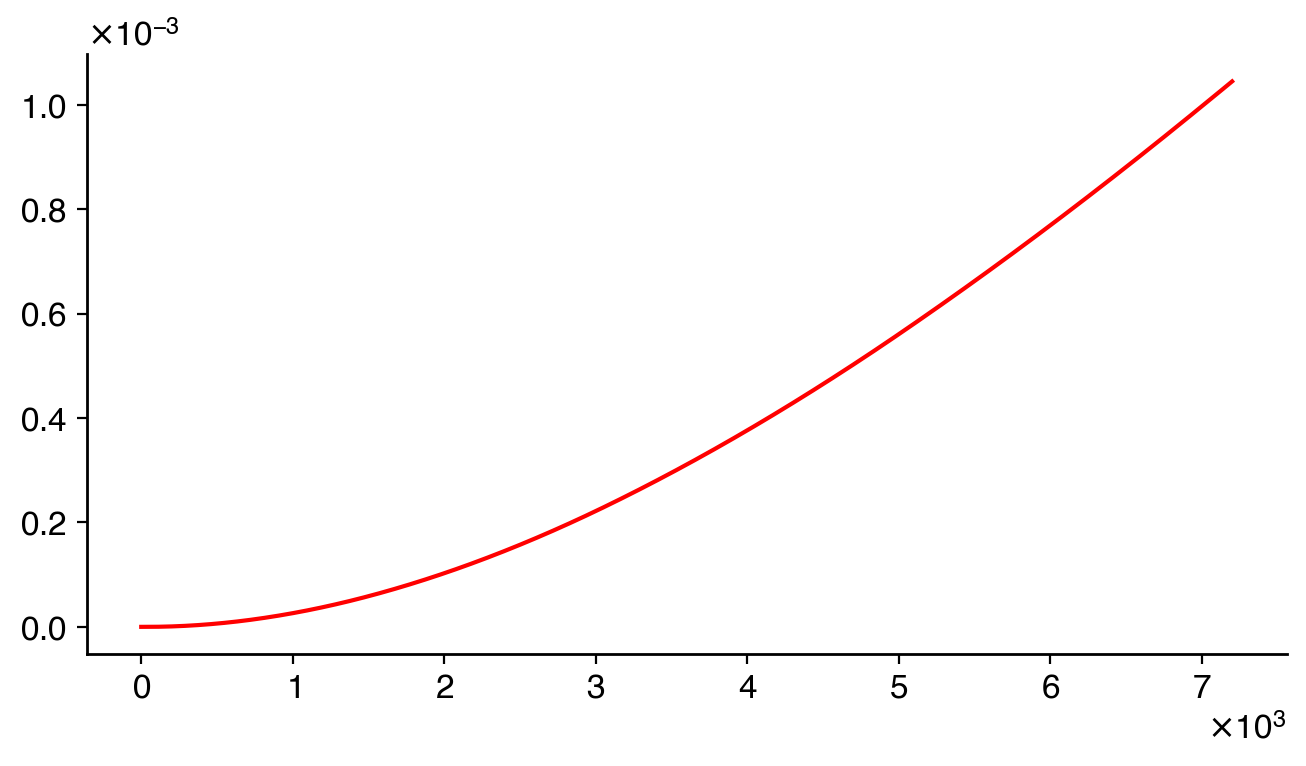

In [13]:
MAPKK_star_star_idx = list(y0_dict.keys()).index('MAPK_tyr')
MAPK_idx = list(y0_dict.keys()).index('MAPK')
MAPK_tyr_idx = list(y0_dict.keys()).index('MAPK_tyr')
fname = '../../figures/MAPK/validation/BI_1999_fig2B'
fig, ax = get_sized_fig_ax(6.0, 3.0)

# ax.plot(BI_1999_fig2b_exp[:, 0], BI_1999_fig2b_exp[:, 1], '^', color='k', label='MAPK - paper (data)')
# ax.plot(BI_1999_fig2b_sim[:, 0], BI_1999_fig2b_sim[:, 1], color='k', label='MAPK - paper')
ax.plot(sol.ts, sol.ys[MAPKK_star_star_idx], color='r', label='MAPK - model')
# ax.plot(sol.ts, sol.ys[MAPK_tyr_idx], color='b', label='MAPK - model')
# ax.plot(sol.ts, sol.ys[MAPK_idx], color='k', label='MAPK - model')


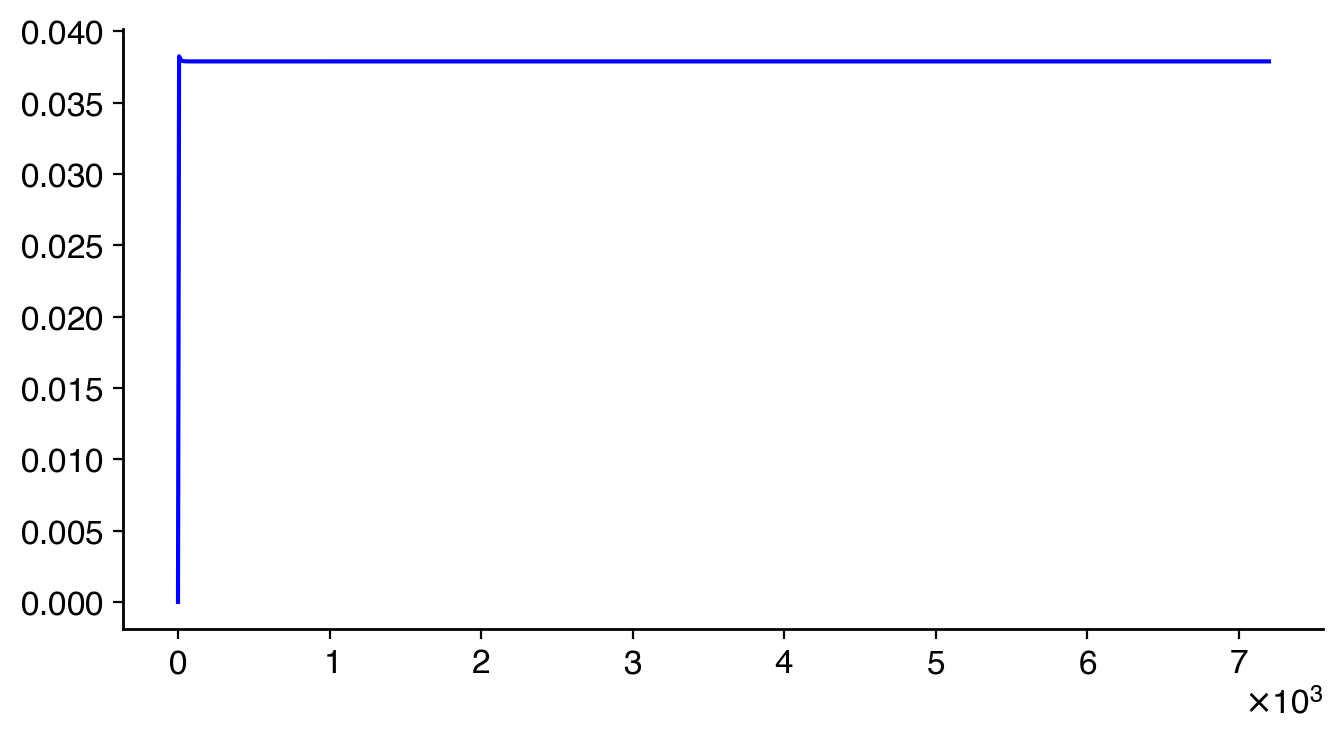

In [29]:
names = ['CaGqPLC', 'CaPLC', 'Ca2CaM', 'Ca3CaM', 'Ca4CAM', 'CaPLCg', 'CaPLCg_star', 'DAGCaPKC', 'CaPKC',  'CaPLA2', 'PIP2CaPLA2', 'DAGCaPLA2', 'CaPLA2_star']

tot = np.zeros(sol.ts.shape)
for name in names:
    tot += sol.ys[list(y0_dict.keys()).index(name)]
fig, ax = get_sized_fig_ax(6.0, 3.0)
# ax.plot(sol.ts, Raf_tot, color='r')
ax.plot(sol.ts, tot, color='b')

## Kholodenko 2000
Recreate figure 1A with sustained oscillations

In [ ]:
K_2000 = kholodenko_2000()
y0_dict, y0 = K_2000.get_initial_conditions()
p_dict, plist = K_2000.get_nominal_params()

plist[0] = 0.025*plist[0]
sol_0 = simulate_model_trajectory(K_2000, y0, plist, t1=2400)

p_dict, plist = K_2000.get_nominal_params()
sol_1 = simulate_model_trajectory(K_2000, y0, plist, t1=8400)

# load data from the paper
K_2000_ppERK = pd.read_csv('./paper_data/kholodenko_2000_fig1A_ppERK.csv').to_numpy()
K_2000_ERK = pd.read_csv('./paper_data/kholodenko_2000_fig1A_ERK.csv').to_numpy()

print(K_2000_ppERK.shape)

In [ ]:
fname = '../../figures/MAPK/validation/K_2000_fig1A'

fig, ax = get_sized_fig_ax(6.0, 3.0)
ax.plot((sol_0.ts-sol_0.ts[-1])/60, sol_0.ys[-1], color='b', label='', alpha=0.5)
# ax.plot(sol_0.ts-sol_0.ts[-1], sol_0.ys[-2], ':', color='b', label='pERK - model')
ax.plot((sol_0.ts-sol_0.ts[-1])/60, p_dict['MAPK_total']-sol_0.ys[-1]-sol_0.ys[-2], '--', color='b', label='', alpha=0.5)
ax.plot([0,0], [-10,310], color='k', linewidth=4)

ax.plot(sol_1.ts/60, sol_1.ys[-1], color='b', label='ppERK - model')
# ax.plot(sol_1.ts, sol_1.ys[-2], ':', color='b', label='pERK - model')
ax.plot(sol_1.ts/60, p_dict['MAPK_total']-sol_1.ys[-1]-sol_1.ys[-2], '--', color='b', label='ERK - model')

ax.plot(K_2000_ppERK[:, 0], K_2000_ppERK[:, 1], color='k', label='ppERK - paper', linewidth=1)
ax.plot(K_2000_ERK[:, 0], K_2000_ERK[:, 1], '--', color='k', label='ERK - paper', linewidth=1)

ax.set_ylim([0, 310])
ax.set_xlim([-40, 141])
ax.set_xlabel('Time (min)')
ax.set_ylabel('Species Concentration (nM)')
ax.set_title('Kholodenko 2000 model - Fig 1A')

leg = ax.legend(fontsize=10)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

## Levchenko 2000

In [13]:
L_2000 = levchenko_2000()
y0_dict, y0 = L_2000.get_initial_conditions()
p_dict, plist = L_2000.get_nominal_params()

p_dict['kOff4'] = 5.0 # this is an order of magnitude higher than the nominal value
plist = [p_dict[k] for k in p_dict.keys()]

# change scaffold concentration
scaffold_concs = [0.0, 0.01, 0.05, 0.1, 0.2, 1.0]
sols = {}
for saffold_conc in scaffold_concs:
    y0_dict['C1'] = saffold_conc
    y0 = tuple([y0_dict[key] for key in y0_dict.keys()])
    sol = simulate_model_trajectory(L_2000, y0, plist, t1=500)
    sols[saffold_conc] = sol

In [4]:
# load paper data
L_2000_fig2A_0 = pd.read_csv('./paper_data/levchenko_2000_fig2A_0.csv').to_numpy()
L_2000_fig2A_001 = pd.read_csv('./paper_data/levchenko_2000_fig2A_001.csv').to_numpy()
L_2000_fig2A_005 = pd.read_csv('./paper_data/levchenko_2000_fig2A_005.csv').to_numpy()
L_2000_fig2A_01 = pd.read_csv('./paper_data/levchenko_2000_fig2A_01.csv').to_numpy()
L_2000_fig2A_02 = pd.read_csv('./paper_data/levchenko_2000_fig2A_02.csv').to_numpy()
L_2000_fig2A_1 = pd.read_csv('./paper_data/levchenko_2000_fig2A_1.csv').to_numpy()

15


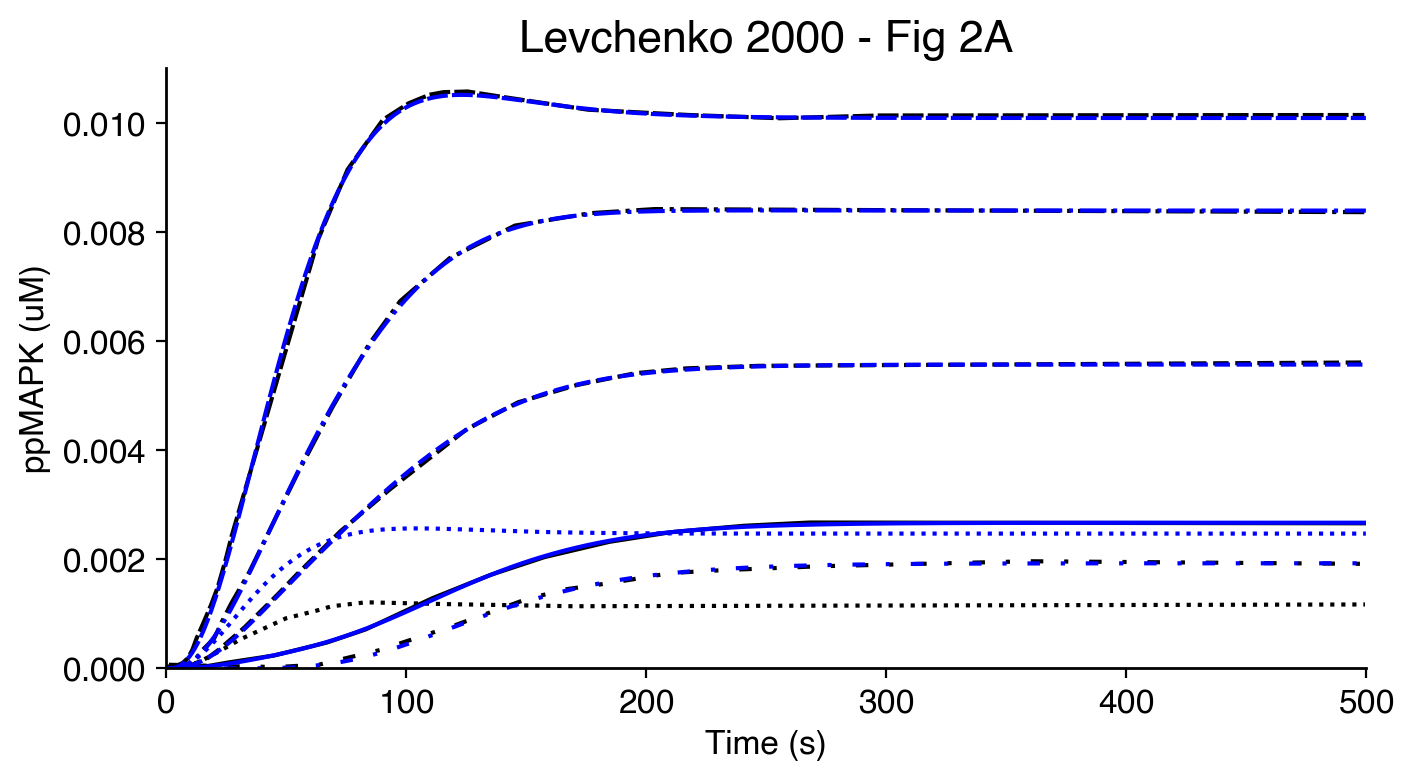

In [16]:
C1_idx = list(y0_dict.keys()).index('C1')
C2_idx = list(y0_dict.keys()).index('C2')
C3_idx = list(y0_dict.keys()).index('C3')
C4_idx = list(y0_dict.keys()).index('C4')
C5_idx = list(y0_dict.keys()).index('C5')
C6_idx = list(y0_dict.keys()).index('C6')
C7_idx = list(y0_dict.keys()).index('C7')
C8_idx = list(y0_dict.keys()).index('C8')
C9_idx = list(y0_dict.keys()).index('C9')

MAPK_idx = list(y0_dict.keys()).index('MAPK')
MAPKstar_idx = list(y0_dict.keys()).index('MAPKstar')
MAPK_MEKstarstar_idx = list(y0_dict.keys()).index('MAPK_MEKstarstar')
MAPKstar_MEKstarstar_idx = list(y0_dict.keys()).index('MAPKstar_MEKstarstar')
MAPKstar_MAPKPase_idx = list(y0_dict.keys()).index('MAPKstar_MAPKPase')
MAPKstarstar_idx = list(y0_dict.keys()).index('MAPKstarstar')
MAPKstarstar_MAPKPase_idx = list(y0_dict.keys()).index('MAPKstarstar_MAPKPase')

MEK_idx = list(y0_dict.keys()).index('MEK')
MEK_RAFstar_idx = list(y0_dict.keys()).index('MEK_RAFstar')
MEKstar_idx = list(y0_dict.keys()).index('MEKstar')
MEKstar_MEKPase_idx = list(y0_dict.keys()).index('MEKstar_MEKPase')
MEKstar_RAFstar_idx = list(y0_dict.keys()).index('MEKstar_RAFstar')
MEKstarstar_idx = list(y0_dict.keys()).index('MEKstarstar')
MEKstarstar_MEKPase_idx = list(y0_dict.keys()).index('MEKstarstar_MEKPase')

RAF_idx = list(y0_dict.keys()).index('RAF')
RAF_RAFact_idx = list(y0_dict.keys()).index('RAF_RAFact')
RAFstar_idx = list(y0_dict.keys()).index('RAFstar')
RAFstar_RAFPase_idx = list(y0_dict.keys()).index('RAFstar_RAFPase')

fig, ax = get_sized_fig_ax(6.0, 3.0)
linestyles = ['-', '--', '-.', (0, (5, 1)), ':', (0, (3, 5, 1, 5))]
fname = '../../figures/MAPK/validation/L_2000_fig2A'

ax.plot(L_2000_fig2A_0[:, 0], L_2000_fig2A_0[:, 1], color='k', label='C1 = 0.0 (paper)', linestyle=linestyles[5])
ax.plot(L_2000_fig2A_001[:, 0], L_2000_fig2A_001[:, 1], color='k', label='C1 = 0.01 (paper)', linestyle=linestyles[0])
ax.plot(L_2000_fig2A_005[:, 0], L_2000_fig2A_005[:, 1], color='k', label='C1 = 0.05 (paper)', linestyle=linestyles[1])
ax.plot(L_2000_fig2A_01[:, 0], L_2000_fig2A_01[:, 1], color='k', label='C1 = 0.1 (paper)', linestyle=linestyles[2])
ax.plot(L_2000_fig2A_02[:, 0], L_2000_fig2A_02[:, 1], color='k', label='C1 = 0.2 (paper)', linestyle=linestyles[3])
ax.plot(L_2000_fig2A_1[:, 0], L_2000_fig2A_1[:, 1], color='k', label='C1 = 1.0 (paper)', linestyle=linestyles[4])

ax.plot(sol.ts, sols[0.0].ys[MAPKstarstar_idx], color='b', label='C1 = 0.0', linestyle=linestyles[5])
ax.plot(sol.ts, sols[0.01].ys[MAPKstarstar_idx], color='b', label='C1 = 0.01', linestyle=linestyles[0])
ax.plot(sol.ts, sols[0.05].ys[MAPKstarstar_idx], color='b', label='C1 = 0.05', linestyle=linestyles[1])
ax.plot(sol.ts, sols[0.1].ys[MAPKstarstar_idx], color='b', label='C1 = 0.1', linestyle=linestyles[2])
ax.plot(sol.ts, sols[0.2].ys[MAPKstarstar_idx], color='b', label='C1 = 0.2', linestyle=linestyles[3])
ax.plot(sol.ts, sols[1.0].ys[MAPKstarstar_idx], color='b', label='C1 = 1.0', linestyle=linestyles[4])

ax.set_xlabel('Time (s)')
ax.set_ylabel('ppMAPK (uM)')
ax.set_title('Levchenko 2000 - Fig 2A')
ax.set_xlim([0, 500])
ax.set_ylim([0, 0.011])


leg = ax.legend(fontsize=10, ncols=3)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

plot to check that the model is working and conserving mass

In [ ]:
C1_tot_01 = sols[0.1].ys[C1_idx]+sols[0.1].ys[C2_idx]+sols[0.1].ys[C3_idx]+sols[0.1].ys[C4_idx]+sols[0.1].ys[C5_idx]+sols[0.1].ys[C6_idx]+sols[0.1].ys[C7_idx]+sols[0.1].ys[C8_idx]+sols[0.1].ys[C9_idx]

MEK_tot = sols[0.1].ys[MEK_idx]+sols[0.1].ys[MEK_RAFstar_idx]+sols[0.1].ys[MEKstar_idx]+sols[0.1].ys[MEKstar_MEKPase_idx]+sols[0.1].ys[MEKstar_RAFstar_idx]+sols[0.1].ys[MEKstarstar_idx]+sols[0.1].ys[MEKstarstar_MEKPase_idx]+sols[0.1].ys[MAPK_MEKstarstar_idx]+sols[0.1].ys[MAPKstar_MEKstarstar_idx]+sols[0.1].ys[C2_idx]+sols[0.1].ys[C3_idx]+sols[0.1].ys[C6_idx]+sols[0.1].ys[C7_idx]+sols[0.1].ys[C8_idx]+sols[0.1].ys[C9_idx]

MAPK_tot = sols[0.1].ys[MAPK_idx]+sols[0.1].ys[MAPKstar_idx]+sols[0.1].ys[MAPK_MEKstarstar_idx]+sols[0.1].ys[MAPKstar_MEKstarstar_idx]+sols[0.1].ys[MAPKstarstar_idx]+sols[0.1].ys[MAPKstarstar_MAPKPase_idx]+sols[0.1].ys[MAPKstar_MAPKPase_idx]+sols[0.1].ys[C4_idx]+sols[0.1].ys[C5_idx]+sols[0.1].ys[C6_idx]+sols[0.1].ys[C7_idx]+sols[0.1].ys[C8_idx]+sols[0.1].ys[C9_idx]

RAF_tot = sols[0.1].ys[RAF_idx]+sols[0.1].ys[RAF_RAFact_idx]+sols[0.1].ys[RAFstar_idx]+sols[0.1].ys[RAFstar_RAFPase_idx]+sols[0.1].ys[MEK_RAFstar_idx]+sols[0.1].ys[MEKstar_RAFstar_idx]



fig, ax = get_sized_fig_ax(6.0, 3.0)
ax.plot(sols[0.1].ts, C1_tot_01, color='b')
ax.plot(sols[0.1].ts, MEK_tot, color='k')
ax.plot(sols[0.1].ts, MAPK_tot, color='r')
ax.plot(sols[0.1].ts, RAF_tot, color='c')
# ax.plot(sols[0.1].ts, sols[0.1].ys[C1_idx])
# ax.plot(sols[0.1].ts, sols[0.1].ys[C2_idx])
# ax.plot(sols[0.1].ts, sols[0.1].ys[C3_idx])
# ax.plot(sols[0.1].ts, sols[0.1].ys[C4_idx])
# ax.plot(sols[0.1].ts, sols[0.1].ys[C5_idx])
# ax.plot(sols[0.1].ts, sols[0.1].ys[C6_idx])
# ax.plot(sols[0.1].ts, sols[0.1].ys[C7_idx])
# ax.plot(sols[0.1].ts, sols[0.1].ys[C8_idx])
# ax.plot(sols[0.1].ts, sols[0.1].ys[C9_idx])
# ax.plot(sol.ts, MAPK_tot, '--', color='b')
# ax.plot(sol.ts, sol.ys[MAPKstarstar_MAPKPase_idx], '--', color='b', label='MAPKstarstar - model')


## Brightman and Fell 2000

In [ ]:
BF_2000 = brightman_fell_2000()
pdict, plist = BF_2000.get_nominal_params()

# update EGF to a more reasonable value
# This is 100 nM assuming a cell volume of 1e-9 L
y0_dict, y0 = BF_2000.get_initial_conditions()
y0 = list(y0)
y0[3] = 6.022e7
y0 = tuple(y0)

# run simulation with nominal params
sol = simulate_model_trajectory(BF_2000, y0, plist, t1=60)

# load data
BF_2000_fig2B_MEK = pd.read_csv('./paper_data/brightman_fell_2000_fig2B_MEK.csv').to_numpy()
BF_2000_fig2B_ERK = pd.read_csv('./paper_data/brightman_fell_2000_fig2B_ERK.csv').to_numpy()

fig, ax = get_sized_fig_ax(6.0, 3.0)
fname = '../../figures/MAPK/validation/BF_2000_fig2B'

ax.plot(BF_2000_fig2B_MEK[:, 0], BF_2000_fig2B_MEK[:, 1], ':', color='k', label='ppMEK - paper')
ax.plot(BF_2000_fig2B_ERK[:, 0], BF_2000_fig2B_ERK[:, 1], '--', color='xkcd:blue', label='ppERK - paper')

ax.plot(sol.ts, 100*sol.ys[23]/np.max(sol.ys[23]), color='k', label='ppMEK')
ax.plot(sol.ts, 100*sol.ys[26]/np.max(sol.ys[26]), color='xkcd:blue', label='ppERK')

ax.set_title('Brightman-Fell 2000 model - Fig 2B')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ppMEK, ppERK (% activation)')
ax.set_ylim([0, 110])
ax.set_xlim([0, 60])

leg = ax.legend(fontsize=10)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)


## Schoeberl 2002

In [ ]:
sch_2002 = schoeberl_2002()
y0_dict, y0 = sch_2002.get_initial_conditions()

schoeberl_2002_fig2F_50 = pd.read_csv('./paper_data/schoeberl_2002_fig2F_50.csv').to_numpy()
schoeberl_2002_fig2F_0_5 = pd.read_csv('./paper_data/schoeberl_2002_fig2F_0_5.csv').to_numpy()
schoeberl_2002_fig2F_0_125 = pd.read_csv('./paper_data/schoeberl_2002_fig2F_0_125.csv').to_numpy()

schoeberl_2002_fig2F_50_sim = pd.read_csv('./paper_data/schoeberl_2002_fig2F_50_sim.csv').to_numpy()
schoeberl_2002_fig2F_0_5_sim = pd.read_csv('./paper_data/schoeberl_2002_fig2F_0_5_sim.csv').to_numpy()
schoeberl_2002_fig2F_0_125_sim = pd.read_csv('./paper_data/schoeberl_2002_fig2F_0_125_sim.csv').to_numpy()

In [ ]:
sols = []
EGFs = [50, 0.5, 0.125] # ng/ml
multiplier = (1e-18 * 6.022e23) / 6045 # convert ng/ml to molecules/cell (see physiomproject docs)
for EGF in EGFs:
    y0 = sch_2002.get_initial_conditions()
    y0 = list(y0)
    y0[0] = EGF*multiplier
    y0 = tuple(y0)
    _, plist = sch_2002.get_nominal_params()
    sol = simulate_model_trajectory(sch_2002, y0, plist, t1=60)
    sols.append(sol)

In [ ]:
fname = '../../figures/MAPK/validation/S_2002_fig2F'
fig, ax = get_sized_fig_ax(6.0, 3.0)

colors = ['r', 'xkcd:blue', 'k']
labels = ['Simulated 50 ng/ml', 'Simulated 0.5 ng/ml', 'Simulated 0.125 ng/ml']
for i, sol in enumerate(sols):
    ax.plot(sol.ts, sol.ys[58]+sol.ys[82], color=colors[i], label=labels[i])

ax.plot(schoeberl_2002_fig2F_50[:,0], schoeberl_2002_fig2F_50[:,1], 'o', color='r', label='50 ng/ml - paper data')
ax.plot(schoeberl_2002_fig2F_50_sim[:,0], schoeberl_2002_fig2F_50_sim[:,1], 'r:', label='50 ng/ml - paper simulation')
ax.plot(schoeberl_2002_fig2F_0_5[:,0], schoeberl_2002_fig2F_0_5[:,1], 's', color='xkcd:blue', label='0.5 ng/ml - paper data')
ax.plot(schoeberl_2002_fig2F_0_5_sim[:,0], schoeberl_2002_fig2F_0_5_sim[:,1], ':', color='xkcd:blue', label='0.5 ng/ml - paper simulation')
ax.plot(schoeberl_2002_fig2F_0_125[:,0], schoeberl_2002_fig2F_0_125[:,1], '^', color='k', label='0.125 ng/ml - paper data')
ax.plot(schoeberl_2002_fig2F_0_125_sim[:,0], schoeberl_2002_fig2F_0_125_sim[:,1], 'k:', label='0.125 ng/ml - paper simulation')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ppERK (molecules/cell)')
ax.set_title('Schoeberl 2002 model - Fig 2F')
ax.set_ylim([0, 1.2e7])
ax.set_xlim([0, 60])

leg = ax.legend(fontsize=10, ncols=2,)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

## Hatakeyama 2003

In [ ]:
HK_2003 = hatakeyama_2003()
pdict, plist = HK_2003.get_nominal_params()
y0_dict = y0 = HK_2003.get_initial_conditions()

state_names = ['R', 'Shc', 'PI3K', 'HRG', 'R_HRG', 'R_HRG2', 'Internalisation', 'RP', 'R_Shc', 'R_ShP', 'ShP', 'R_ShGS', 'ShGS', 'GS', 'R_PI3K', 'R_PI3Kstar', 'PI3Kstar', 'RasGTP', 'RasGDP', 'Akt_PIPP', 'RAF_star', 'RAF', 'MEKP', 'MEKPP', 'P', 'PIP3', 'Akt', 'Akt_PIP3', 'Akt_PIP', 'MEK', 'ERK', 'ERKP', 'ERKPP']

# load paper data
HK_RAF_star_0_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4D_thick_dash.csv').to_numpy()
HK_RAF_star_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4D_thin_dash.csv').to_numpy()
HK_RAF_star_10 = pd.read_csv('./paper_data/hatakeyama_2003_fig4D_solid.csv').to_numpy()

HK_MEKPP_0_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4E_thick_dash.csv').to_numpy()
HK_MEKPP_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4E_thin_dash.csv').to_numpy()
HK_MEKPP_10 = pd.read_csv('./paper_data/hatakeyama_2003_fig4E_solid.csv').to_numpy()
HK_MEKPP_dat_0_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4E_tri_data.csv').to_numpy()
HK_MEKPP_dat_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4E_circle_data.csv').to_numpy()
HK_MEKPP_dat_10 = pd.read_csv('./paper_data/hatakeyama_2003_fig4E_square_data.csv').to_numpy()

HK_ERKPP_0_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4F_thick_dash.csv').to_numpy()
HK_ERKPP_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4F_thin_dash.csv').to_numpy()
HK_ERKPP_10 = pd.read_csv('./paper_data/hatakeyama_2003_fig4F_solid.csv').to_numpy()
HK_ERKPP_dat_0_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4F_tri_data.csv').to_numpy()
HK_ERKPP_dat_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4F_circle_data.csv').to_numpy()
HK_ERKPP_dat_10 = pd.read_csv('./paper_data/hatakeyama_2003_fig4F_square_data.csv').to_numpy()

# run sims at different HRG concentrations
sols = {}
HRGs = [0.1, 1, 10]
for HRG in HRGs:
    y0 = HK_2003.get_initial_conditions()
    y0 = list(y0)
    y0[3] = HRG*1e2
    y0 = tuple(y0)
    sol = simulate_model_trajectory(HK_2003, y0, plist, t1=3600)
    sols[HRG] = sol

In [ ]:
fname = '../../figures/MAPK/validation/H_2003'

# Raf_star
fig, ax = get_sized_fig_ax(2.0, 3.0)
# sims from the paper
ax.plot(HK_RAF_star_0_1[:, 0], HK_RAF_star_0_1[:, 1], '--', color='k', label='HRG=0.1 - paper')
ax.plot(HK_RAF_star_1[:, 0], HK_RAF_star_1[:, 1], ':', color='k', label='HRG=1 - paper')
ax.plot(HK_RAF_star_10[:, 0], HK_RAF_star_10[:, 1], '-', color='k', label='HRG=10 - paper')

# sims from this model
ax.plot(sols[0.1].ts, sols[0.1].ys[20], '--', color='xkcd:blue', label='HRG=0.1 - simulation')
ax.plot(sols[1].ts, sols[1].ys[20], ':', color='xkcd:blue', label='HRG=1 - simulation')
ax.plot(sols[10].ts, sols[10].ys[20], '-', color='xkcd:blue', label='HRG=10 - simulation')

ax.set_title('Hatakeyama 2003 \n Fig 4D')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Raf* (%)')
ax.set_xlim([0, 1810])
ax.set_ylim([0, 4.1])

fig.savefig(fname+'_fig4D'+'_fig.pdf', bbox_inches='tight', transparent=True)


# MEKPP
fig, ax = get_sized_fig_ax(2.0, 3.0)
# sims from the paper
ax.plot(HK_MEKPP_0_1[:, 0], HK_MEKPP_0_1[:, 1], '--', color='k', label='HRG=0.1 - paper')
ax.plot(HK_MEKPP_1[:, 0], HK_MEKPP_1[:, 1], ':', color='k', label='HRG=1 - paper')
ax.plot(HK_MEKPP_10[:, 0], HK_MEKPP_10[:, 1], '-', color='k', label='HRG=10 - paper')
# data
ax.scatter(HK_MEKPP_dat_0_1[:, 0], HK_MEKPP_dat_0_1[:, 1], marker='^', color='k', label='HRG=0.1 - paper data', facecolors='none', linewidth=0.75)
ax.scatter(HK_MEKPP_dat_1[:, 0], HK_MEKPP_dat_1[:, 1], marker='o', color='k', label='HRG=1 - paper data', facecolors='none', linewidth=0.75,)
ax.scatter(HK_MEKPP_dat_10[:, 0], HK_MEKPP_dat_10[:, 1], marker='s', color='k', label='HRG=10 - paper data', facecolors='none', linewidth=0.75,)

# sims from this model
ax.plot(sols[0.1].ts, 100*sols[0.1].ys[23]/120, '--', color='xkcd:blue', label='HRG=0.1 - simulation')
ax.plot(sols[1].ts, 100*sols[1].ys[23]/120, ':', color='xkcd:blue', label='HRG=1 - simulation')
ax.plot(sols[10].ts, 100*sols[10].ys[23]/120, '-', color='xkcd:blue', label='HRG=10 - simulation')

ax.set_title('Hatakeyama 2003 \n Fig 4E')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('ppMEK (% activation)')
ax.set_xlim([0, 1810])
ax.set_ylim([0, 95])

leg = ax.legend(fontsize=8, ncol=3)
export_legend(leg, filename=fname+'_fig4E'+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig4E'+'_fig.pdf', bbox_inches='tight', transparent=True)

# ERKPP
fig, ax = get_sized_fig_ax(2.0, 3.0)
# sims from the paper
ax.plot(HK_ERKPP_0_1[:, 0], HK_ERKPP_0_1[:, 1], '--', color='k', label='HRG=0.1 - paper')
ax.plot(HK_ERKPP_1[:, 0], HK_ERKPP_1[:, 1], ':', color='k', label='HRG=1 - paper')
ax.plot(HK_ERKPP_10[:, 0], HK_ERKPP_10[:, 1], '-', color='k', label='HRG=10 - paper')
# data
ax.scatter(HK_ERKPP_dat_0_1[:, 0], HK_ERKPP_dat_0_1[:, 1], marker='^', color='k', label='HRG=0.1 - paper data', facecolors='none', linewidth=0.75)
ax.scatter(HK_ERKPP_dat_1[:, 0], HK_ERKPP_dat_1[:, 1], marker='o', color='k', label='HRG=1 - paper data', facecolors='none', linewidth=0.75,)
ax.scatter(HK_ERKPP_dat_10[:, 0], HK_ERKPP_dat_10[:, 1], marker='s', color='k', label='HRG=10 - paper data', facecolors='none', linewidth=0.75,)

# sims from this model
ax.plot(sols[0.1].ts, 100*sols[0.1].ys[32]/1000, '--', color='xkcd:blue', label='HRG=0.1 - simulation')
ax.plot(sols[1].ts, 100*sols[1].ys[32]/1000, ':', color='xkcd:blue', label='HRG=1 - simulation')
ax.plot(sols[10].ts, 100*sols[10].ys[32]/1000, '-', color='xkcd:blue', label='HRG=10 - simulation')

ax.set_title('Hatakeyama 2003 \n Fig 4F')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('ERKPP (%)')
ax.set_xlim([0, 1810])
ax.set_ylim([0, 95])


fig.savefig(fname+'_fig4F'+'_fig.pdf', bbox_inches='tight', transparent=True)

## Hornberg 2005
Note: This model is an updated version of the Schoeberl 2002 model.

In [ ]:
HB_2005 = hornberg_2005()
pdict, plist = HB_2005.get_nominal_params()
y0_dict, y0 = HB_2005.get_initial_conditions()

sol = simulate_model_trajectory(HB_2005, y0, plist, t1=6000)

# load paper data
HB_2005_fig2_ERKpp = pd.read_csv('./paper_data/hornberg_2005_fig2.csv').to_numpy()

In [ ]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
fname = '../../figures/MAPK/validation/H_2005_fig2'

ax.plot(HB_2005_fig2_ERKpp[:, 0], HB_2005_fig2_ERKpp[:, 1], '-', color='k', label='paper simulation')
ax.plot(sol.ts/60, sol.ys[58]+sol.ys[82], '--', color='xkcd:blue', label='simulation')
ax.set_title('Hornberg 2005 - Fig 2')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ppERK (molecules/cell)')
ax.set_xlim([0, 100])
ax.set_ylim([0, 1.2e7])

leg = ax.legend(fontsize=10)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

## Birtwistle 2007

In [17]:
BW_2007 = birtwistle_2007()
pdict, plist = BW_2007.get_nominal_params()
y0_dict, y0 = BW_2007.get_initial_conditions()

# run the simulation
EGFs = [0, 0.5, 10]
HRGs = [0.5, 0]
sols = {}
for EGF in EGFs:
    for HRG in HRGs:
        y0dict, y0 = BW_2007.get_initial_conditions()
        # y0dict['ERKstar_ERKpase'] = 0.0
        y0dict['E'] = EGF
        y0dict['H'] = HRG
        y0 = tuple(y0dict.values())
        # if EGF or HRG:
        sol = simulate_model_trajectory(BW_2007, y0, plist, t1=1800)
        sols[(EGF, HRG)] = sol

        if sol.result > 0:
            print('EGF={}, HRG={} failed'.format(EGF, HRG))
        else:
            print('EGF={}, HRG={} succeeded'.format(EGF, HRG))
        # else:
        #     print('skipping EGF=0, HRG=0')

EGF=0, HRG=0.5 succeeded
EGF=0, HRG=0 succeeded
EGF=0.5, HRG=0.5 succeeded
EGF=0.5, HRG=0 succeeded
EGF=10, HRG=0.5 succeeded
EGF=10, HRG=0 succeeded


In [45]:
# load data from the paper
BW_2007_egf0 = pd.read_csv('./paper_data/birtwistle_2007_fig4A_egf0_data.csv').to_numpy()
BW_2007_egf0_5 = pd.read_csv('./paper_data/birtwistle_2007_fig4A_egf0_5_data.csv').to_numpy()
BW_2007_egf10 = pd.read_csv('./paper_data/birtwistle_2007_fig4A_egf10_data.csv').to_numpy()

# load sims from the paper
BW_2007_solid = pd.read_csv('./paper_data/birtwistle_2007_fig4A_solid_sim.csv').to_numpy()
BW_2007_thick_dash = pd.read_csv('./paper_data/birtwistle_2007_fig4A_thick_dash_sim.csv').to_numpy()
BW_2007_thin_dash = pd.read_csv('./paper_data/birtwistle_2007_fig4A_thin_dash_sim.csv').to_numpy()

dat = np.vstack((sols[(0, 0.5)].ys[75]+sols[(0, 0.5)].ys[115], sols[(0.5, 0.5)].ys[75]+sols[(0.5, 0.5)].ys[115], sols[(10, 0.5)].ys[75]+sols[(10, 0.5)].ys[115], sols[(0.5, 0)].ys[75]+sols[(0.5, 0)].ys[115], sols[(10, 0)].ys[75]+sols[(10, 0)].ys[115]))
dat[dat==np.inf] = np.nan
normalization = np.nanmax(dat)

In [51]:
y0_dict['ERK']

750.0

115
75


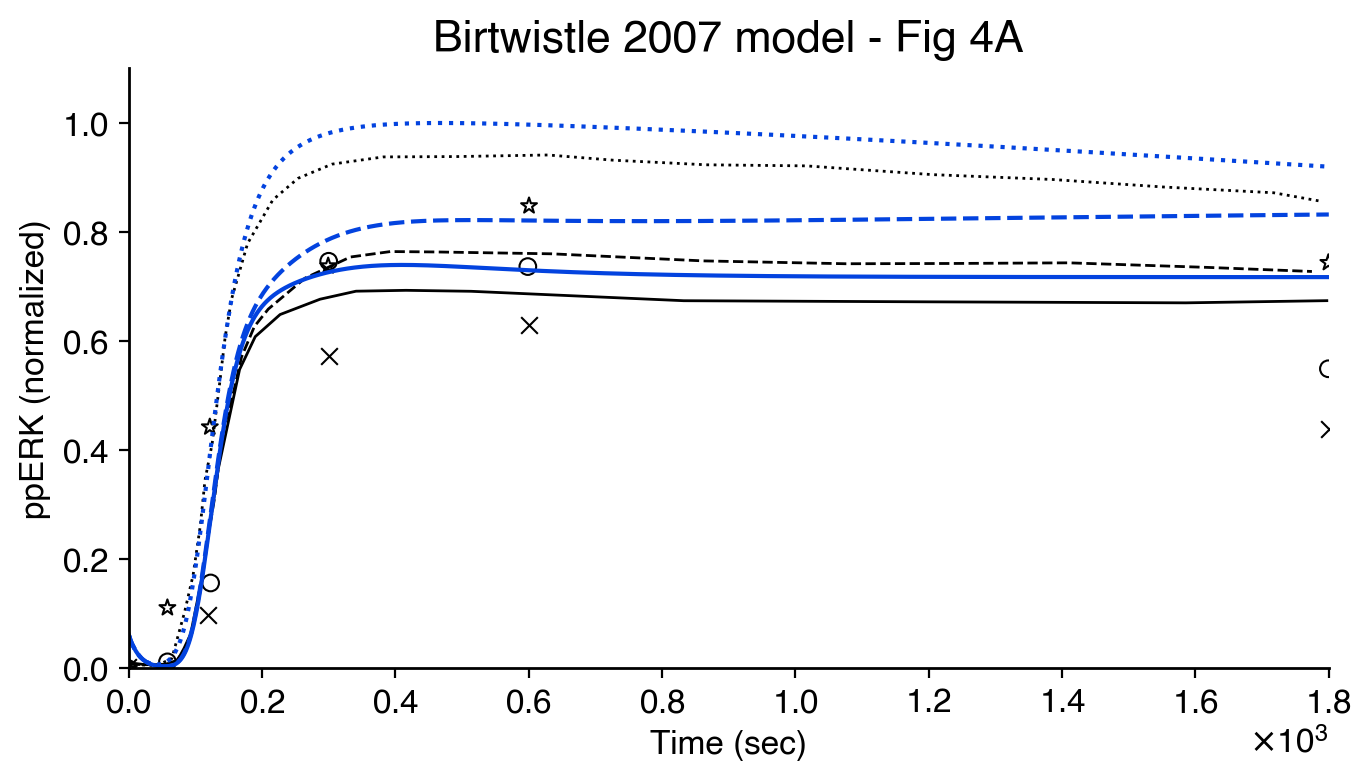

In [47]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
fname = '../../figures/MAPK/validation/B_2007_fig4A'

ERK_star_idx = list(y0_dict.keys()).index('ERKstar')
ERKstar_ERKpase_idx = list(y0_dict.keys()).index('ERKstar_ERKpase')
print(ERKstar_ERKpase_idx)
print(ERK_star_idx)

# plot data
ax.scatter(BW_2007_egf0[:, 0], BW_2007_egf0[:, 1], marker='x', color='k', label='EGF=0 - paper', linewidth=0.75)
ax.scatter(BW_2007_egf0_5[:, 0], BW_2007_egf0_5[:, 1], label='EGF= 0.5 - paper', facecolors='none', edgecolor='k', marker='o', linewidth=0.75)
ax.scatter(BW_2007_egf10[:, 0], BW_2007_egf10[:, 1], label='EGF=10.0 - paper', facecolors='none', edgecolor='k', marker='*', linewidth=0.75)

# plot simulations from paper
ax.plot(BW_2007_solid[:, 0], BW_2007_solid[:, 1], color='k', label='EGF=0 - paper simulation', linewidth=1.0)
ax.plot(BW_2007_thick_dash[:, 0], BW_2007_thick_dash[:, 1], '--', color='k', label='EGF=0.5 - paper simulation', linewidth=1.0)
ax.plot(BW_2007_thin_dash[:, 0], BW_2007_thin_dash[:, 1], ':', color='k', label='EGF=10.0 - paper simulation', linewidth=1.0)

# plot simulations
ax.plot(sols[(0, 0.5)].ts, ((sols[(0, 0.5)].ys[ERK_star_idx])+(sols[(0, 0.5)].ys[ERKstar_ERKpase_idx]))/normalization,'-', color='xkcd:blue', label='EGF=0 - simulation')
ax.plot(sols[(0.5, 0.5)].ts, (sols[(0.5, 0.5)].ys[ERK_star_idx]+sols[(0.5, 0.5)].ys[ERKstar_ERKpase_idx])/normalization,'--', color='xkcd:blue', label='EGF=0.5 - simulation')
ax.plot(sols[(10, 0.5)].ts, (sols[(10, 0.5)].ys[ERK_star_idx]+sols[(10, 0.5)].ys[ERKstar_ERKpase_idx])/normalization,':', color='xkcd:blue', label='EGF=10 - simulation')

ax.set_title('Birtwistle 2007 model - Fig 4A')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('ppERK (normalized)')
ax.set_xlim([0, 1800])
ax.set_ylim([0, 1.1])

leg = ax.legend(fontsize=10, ncol=2)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)    

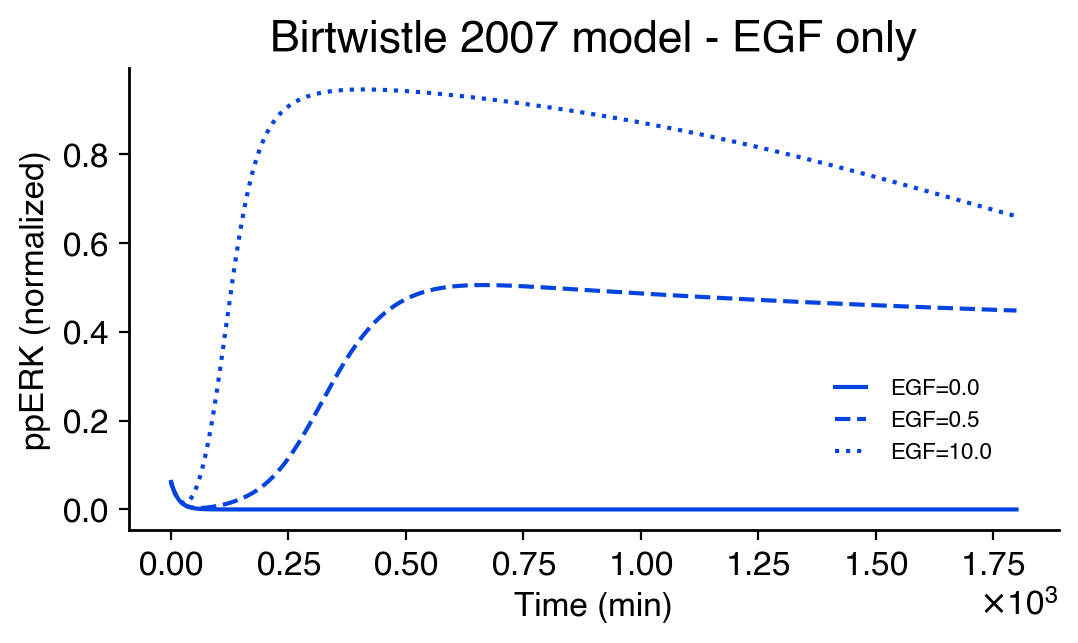

In [20]:
fig, ax = plt.subplots(figsize=(6, 3))

# plot simulations
ax.plot(sols[(0, 0)].ts, (sols[(0, 0)].ys[75]+sols[(0, 0)].ys[115])/normalization,'-', color='xkcd:blue', label='EGF=0.0')
ax.plot(sols[(0.5, 0)].ts, (sols[(0.5, 0)].ys[75]+sols[(0.5, 0)].ys[115])/normalization,'--', color='xkcd:blue', label='EGF=0.5')
ax.plot(sols[(10, 0)].ts, (sols[(10, 0)].ys[75]+sols[(10, 0)].ys[115])/normalization,':', color='xkcd:blue', label='EGF=10.0')

ax.set_title('Birtwistle 2007 model - EGF only')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ppERK (normalized)')
ax.legend(fontsize=8, loc='lower right', bbox_to_anchor=(0.95, 0.1))

E, H, E1, E2, E3, E4, E_E1, H_E3, H_E4, E11, E12, E23, E34, E24, E44, \
E11P, E12P, E23P, E34P, E24P, E44P, G, S, I, R, O, A, E11G, E11S, \
E11R, E12G, E12S, E12R, E23G, E23S, E23I, E23R, E34G, E34S, E34I, \
E34R, E24G, E24S, E24I, E24R, E44G, E44S, E44I, E44R, SigG, SigS, \
SigI, SigR, SigA, SigSP, SigAP, SigG_O, SigG_A, SigSP_G, SigAP_S, \
SigAP_I, SigAP_R, P3_A, P2, P3, Akt, Aktstar, RsD, RsT, SigRP, Raf, \
Rafstar, MEK, MEKstar, ERK, ERKstar, OP, AP, A_SigG_O, SigA_G, \
SigA_G_O, SigO, E13, E14, E13P, E14P, E13G, E13S, E13I, E13R, E14G, \
E14S, E14I, E14R, fint, T, E11T, E12T, E23T, E34T, E24T, E44T, \
E13T, E14T, SigAP_T, SigT, E1_PT, E2_PT, E4_PT, E_E1_PT, H_E4_PT, \
pERK, ERK_MEKstar, pERK_MEKstar, ERKpase, ERKstar_ERKpase, \
pERK_ERKpase

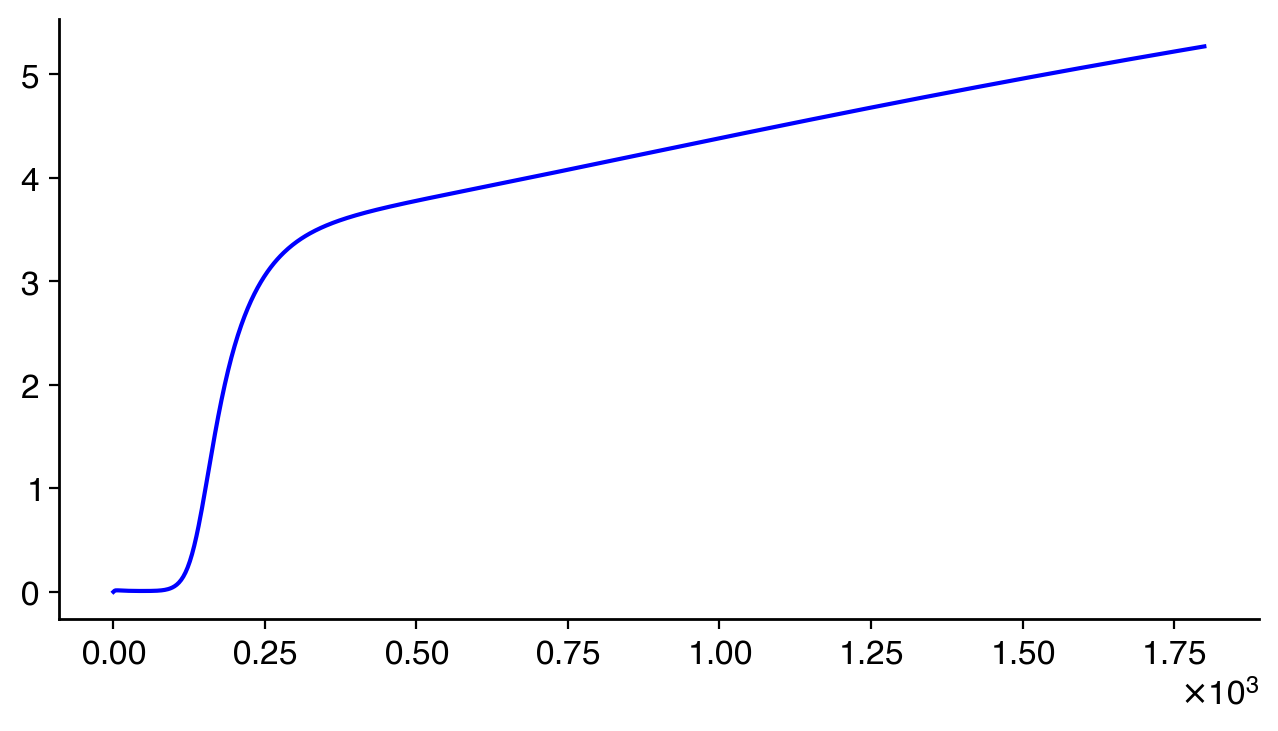

In [38]:
names = ['E_E1', 'E11', 'E12', 'E11P', 'E12P', 'E11T', 'E12T', 'E_E1_PT', 'E11G', 'E11R', 'E11S', 'E12G', 'E12R', 'E12S']
names = ['E_E1', 'E11',  'E11P', 'E11T',  'E_E1_PT', 'E11G', 'E11S', ]

tot = np.zeros(sol.ts.shape)
for name in names:
    tot += sols[(0.5, 0.5)].ys[list(y0_dict.keys()).index(name)]
fig, ax = get_sized_fig_ax(6.0, 3.0)
# ax.plot(sol.ts, Raf_tot, color='r')
ax.plot(sols[(0.5, 0.5)].ts, tot, color='b')

## Orton 2009

In [7]:
OR_2009 = orton_2009()
pdict, plist = OR_2009.get_nominal_params()
y0_dict, y0 = OR_2009.get_initial_conditions()

sol = simulate_model_trajectory(OR_2009, y0, plist, t1=60)

14


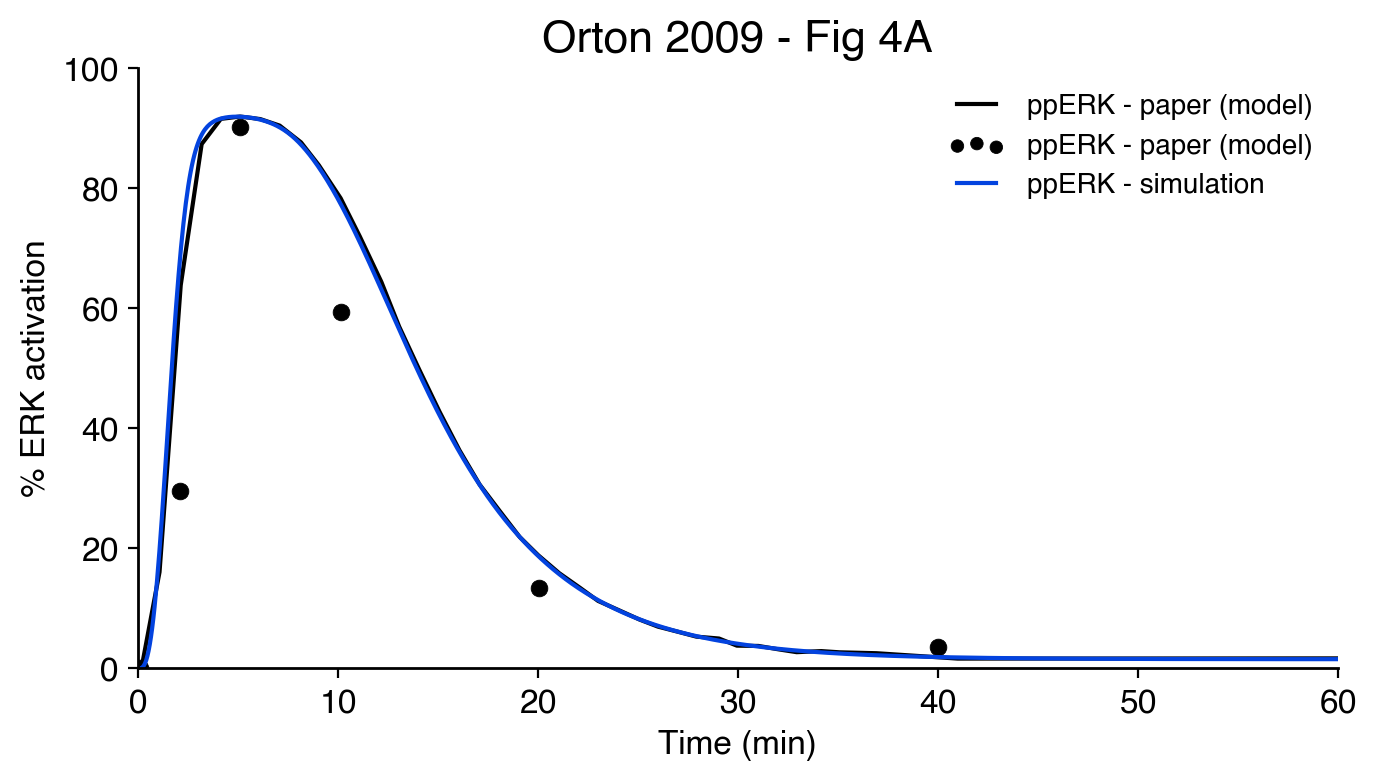

In [9]:
# load data
OR_2009_fig4A_model = pd.read_csv('./paper_data/orton_2009_fig4A_model.csv').to_numpy()
OR_2009_fig4A_data = pd.read_csv('./paper_data/orton_2009_fig4A_data.csv').to_numpy()

fig, ax  = get_sized_fig_ax(6.0, 3.0)
fname = '../../figures/MAPK/validation/O_2009_fig4A'
ax.plot(OR_2009_fig4A_model[:, 0], (OR_2009_fig4A_model[:, 1]/y0_dict['ErkInactive'])*100, '-', color='k', label='ppERK - paper (model)')
ax.scatter(OR_2009_fig4A_data[:, 0], (OR_2009_fig4A_data[:, 1]/y0_dict['ErkInactive'])*100, color='k', label='ppERK - paper (model)')

ERKActive_idx = list(y0_dict.keys()).index('ErkActive')
print(ERKActive_idx)
ax.plot(sol.ts, (sol.ys[ERKActive_idx]/y0_dict['ErkInactive'])*100, '-', color='xkcd:blue', label='ppERK - simulation')

ax.set_title('Orton 2009 - Fig 4A')
ax.set_xlabel('Time (min)')
ax.set_ylabel('% ERK activation')
ax.set_xlim([0, 60])
ax.set_ylim([0, 100])

leg = ax.legend(fontsize=10)
export_legend(leg, filename=fname+'_legend.pdf')

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

## von Kriegsheim 2009

In [3]:
VK_2009 = vonKriegsheim_2009()
pdict, plist = VK_2009.get_nominal_params()
y0_dict, y0 = VK_2009.get_initial_conditions()

y0_dict['EGF'] = 20.0
y0 = tuple([y0_dict[key] for key in y0_dict.keys()])
sol_egf20 = simulate_model_trajectory(VK_2009, y0, plist, t1=1800)

y0_dict['EGF'] = 0.0
y0_dict['NGF'] = 100.0
y0 = tuple([y0_dict[key] for key in y0_dict.keys()])
sol_ngf100 = simulate_model_trajectory(VK_2009, y0, plist, t1=1800)

26 28 29


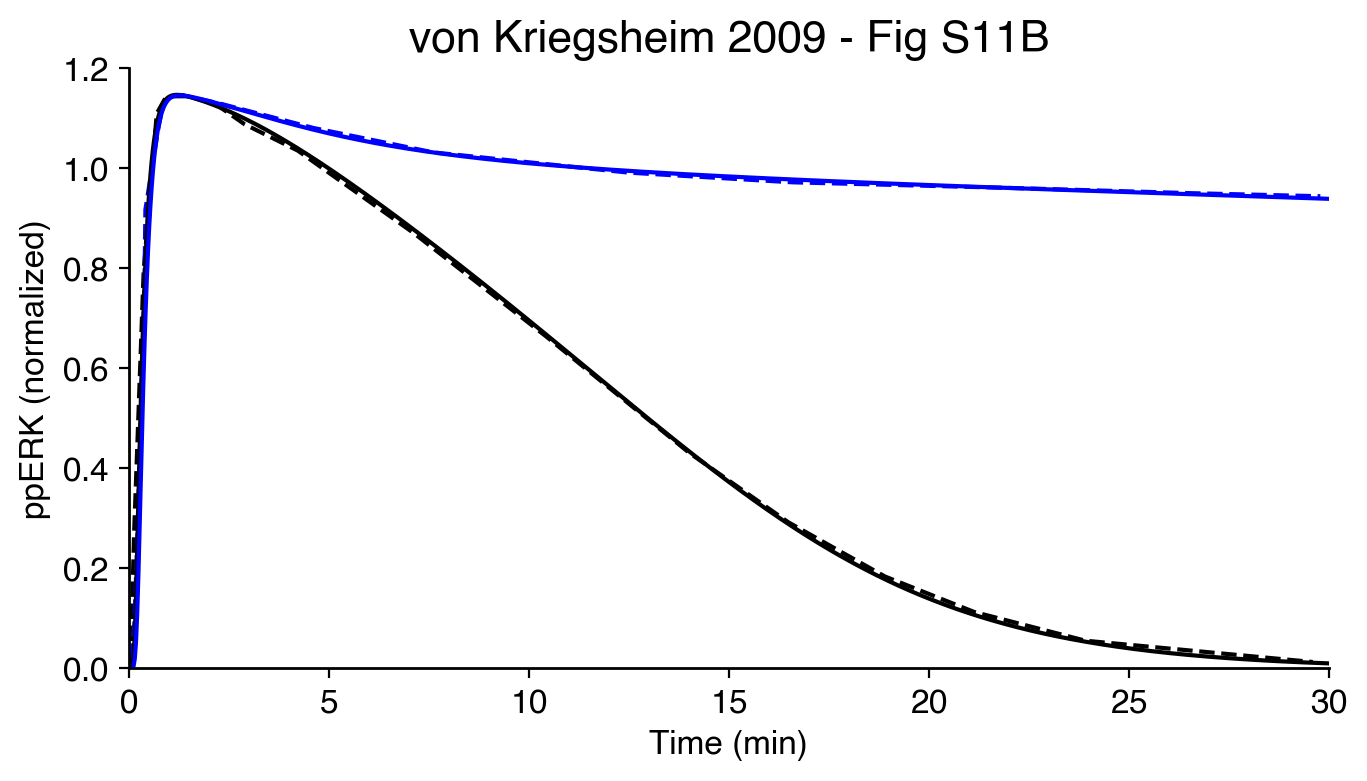

In [5]:
# load figure simulations
VK_2009_figS11B_egf20 = pd.read_csv('./paper_data/vonKriegsheim_2009_figS11B_20egf.csv').to_numpy()
VK_2009_figS11B_ngf100 = pd.read_csv('./paper_data/vonKriegsheim_2009_figS11B_100ngf.csv').to_numpy()

ppERK_idx = list(y0_dict.keys()).index('ppERK')
ppERK_15_idx = list(y0_dict.keys()).index('ppERK_15')
ppERKn_idx = list(y0_dict.keys()).index('ppERKn')

print(ppERK_idx, ppERK_15_idx, ppERKn_idx)

fig, ax = get_sized_fig_ax(6.0, 3.0)
fname = '../../figures/MAPK/validation/VK_2009_figS11B'

norm = 0.701412355126078
egf_egf20 = (sol_egf20.ys[ppERK_idx]/norm) + \
            (sol_egf20.ys[ppERK_15_idx]/norm) + \
            ((sol_egf20.ys[ppERKn_idx]/norm)*pdict['V_NUC']/pdict['V_CYT'])

egf_ngf100 = (sol_ngf100.ys[ppERK_idx]/norm) + \
            (sol_ngf100.ys[ppERK_15_idx]/norm) + \
            ((sol_ngf100.ys[ppERKn_idx]/norm)*pdict['V_NUC']/pdict['V_CYT'])

ax.plot(VK_2009_figS11B_egf20[:, 0], VK_2009_figS11B_egf20[:, 1], '--', color='k', label='EGF=20 - paper')
ax.plot(VK_2009_figS11B_ngf100[:, 0], VK_2009_figS11B_ngf100[:, 1], '--', color='b', label='NGF=100 - paper')
ax.plot(sol_egf20.ts/60, egf_egf20, '-', color='k', label='EGF=20')
ax.plot(sol_ngf100.ts/60, egf_ngf100, '-', color='b', label='NGF=100')

ax.set_xlabel('Time (min)')
ax.set_ylabel('ppERK (normalized)')
ax.set_xlim([0, 30])
ax.set_ylim([0, 1.2])
ax.set_title('von Kriegsheim 2009 - Fig S11B')

leg = ax.legend(fontsize=10)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

## Shin 2014

In [ ]:
SN_2014 = shin_2014()
pdict, plist = SN_2014.get_nominal_params()
y0_dict, y0 = SN_2014.get_initial_conditions()

sols = {}
cols = ['xkcd:blue', 'xkcd:black', 'xkcd:indigo', 'xkcd:red', 'xkcd:gray', 'xkcd:brown', 'xkcd:pink', 'xkcd:gray', 'xkcd:dark yellow']

linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     # ('densely dotted',        (0, (1, 1))),
     ('long dash with offset', (5, (10, 3))),
     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     # ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('', '-'),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

EGFs = [0, 1e-5, 1e-3, 1e-2, 0.1, 0.5, 1, 5, 10]
fig, ax = get_sized_fig_ax(6.0, 3.0)
fname = '../../figures/MAPK/validation/S_2014'
for i, EGF in enumerate(EGFs):
    plist[-1] = EGF
    sol = simulate_model_trajectory(SN_2014, y0, plist, t1=200)
    sols[EGF] = sol

    ax.plot(sol.ts, sol.ys[-1]/pdict['ERK_tot'], '-', color='xkcd:blue', label='EGF={} uM'.format(EGF), linestyle=linestyle_tuple[i][1])
ax.set_title('Shin 2014 model')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ppERK (normalized)')
leg = ax.legend(fontsize=10, ncol=3)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

## Ryu 2015

In [10]:
R_2015 = ryu_2015()
pdict, plist = R_2015.get_nominal_params()
y0_dict, y0 = R_2015.get_initial_conditions()

sols = []
EGFs = [1.0, 100.0]
for EGF in EGFs:
    plist[-1] = EGF
    sol = simulate_model_trajectory(R_2015, y0, plist, t1=60)
    sols.append(sol)

# load data
R_2015_fig5B_egfLOW = pd.read_csv('./paper_data/ryu_2015_fig5B_egfLOW.csv').to_numpy()
R_2015_fig5B_egfHIGH = pd.read_csv('./paper_data/ryu_2015_fig5B_egfHIGH.csv').to_numpy()
R_2015_fig5B_ngfLOW = pd.read_csv('./paper_data/ryu_2015_fig5B_ngfLOW.csv').to_numpy()
R_2015_fig5B_ngfHIGH = pd.read_csv('./paper_data/ryu_2015_fig5B_ngfHIGH.csv').to_numpy()

9


NameError: name 'sols' is not defined

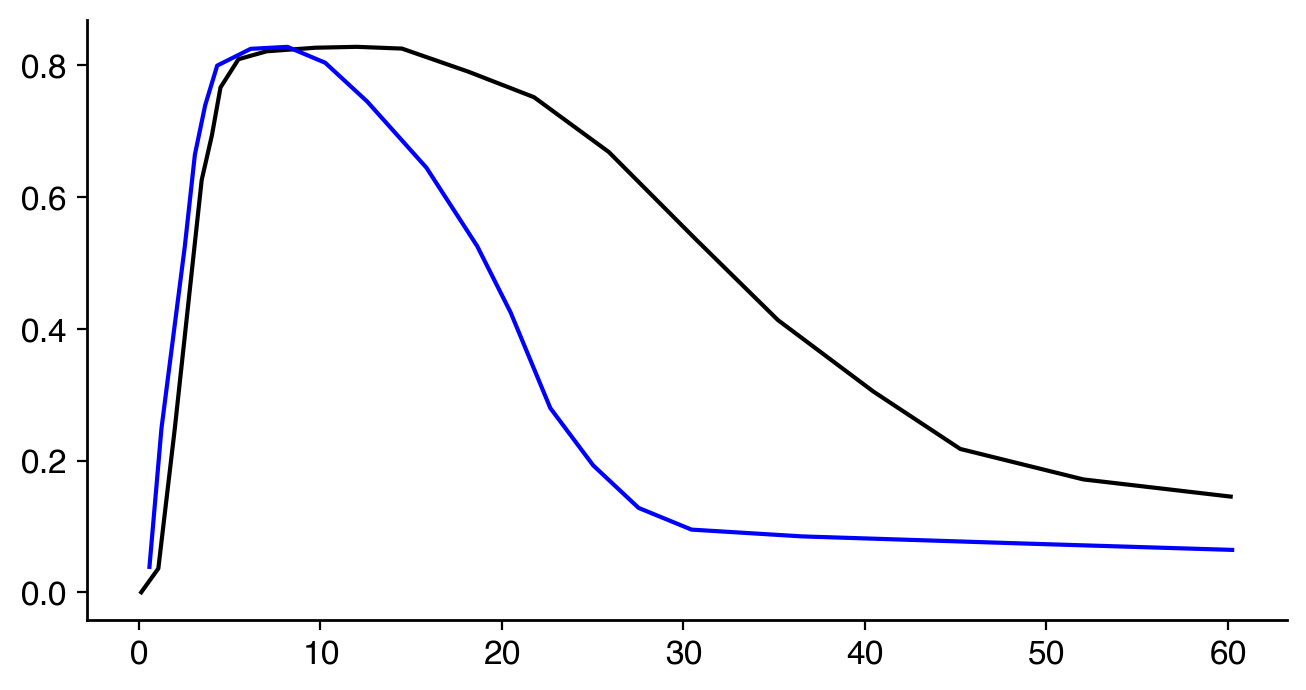

In [11]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
fname = '../../figures/MAPK/validation/R_2015_fig5B_EGF'

ERK_star_idx = list(y0_dict.keys()).index('ERK_star')

ax.plot(R_2015_fig5B_egfLOW[1:, 0], R_2015_fig5B_egfLOW[1:, 1], '-', color='k', label='EGF LOW - paper')
ax.plot(R_2015_fig5B_egfHIGH[1:, 0], R_2015_fig5B_egfHIGH[1:, 1], '-', color='b', label='EGF HIGH - paper')
ax.plot(sols[0].ts, sols[0].ys[ERK_star_idx], '--', color='k', label='EGF LOW - simulation')
ax.plot(sols[1].ts, sols[1].ys[ERK_star_idx], '--', color='b', label='EGF HIGH - simulation')

ax.set_title('Ryu 2015 - Fig 5B')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ERK activation (a.u.)')
ax.set_xlim([0.0, 60.0])
ax.set_ylim([0.0, 0.9])

leg = ax.legend(fontsize=10)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

## Kochanczyk 2017

In [ ]:
K_2017 = kochanczyk_2017()
pdict, plist = K_2017.get_nominal_params()
y0_dict, y0 = K_2017.get_initial_conditions()

tmax = 24*60*60
EGFs = [2.6, 20.0, 200.0] # egf concentrations in pg/mL
sols = {}
for EGF in EGFs:
    pdict, plist = K_2017.get_nominal_params()
    plist[0] = EGF
    print(EGF)
    sol = simulate_model_trajectory(K_2017, y0, plist, t1=tmax)
    sols[EGF] = sol

# import data from bionetgen sims in the paper
K_2017_fig4A = np.load('./paper_data/Kochanczyk_fig4A.npy')
K_2017_fig4B = np.load('./paper_data/Kochanczyk_fig4B.npy')
K_2017_fig4C = np.load('./paper_data/Kochanczyk_fig4C.npy')

In [ ]:
fig, ax = get_sized_fig_ax(6.0, 1.0)
fname = '../../figures/MAPK/validation/K_2017_fig4A'

ax.plot(K_2017_fig4A[0, :]/3600, K_2017_fig4A[1, :]/y0_dict['ERKSU'], '-', color='k', label='EGF=2.6 pg/mL - paper')
ax.plot(sols[2.6].ts/3600, sols[2.6].ys[23]/y0_dict['ERKSU'], '--', color='b', label='EGF=2.6 pg/mL - simulation')
ax.set_xlim([0, 24])
ax.set_ylim([0, 1.0])
ax.set_xlabel('Time (hr)')
ax.set_ylabel('ppERK \n (normalized)')
ax.set_title('Kochanczyk 2017 - Fig 4A')
leg = ax.legend(fontsize=10)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

fig1, ax1 = get_sized_fig_ax(6.0, 1.0)
fname = '../../figures/MAPK/validation/K_2017_fig4B'

ax1.plot(K_2017_fig4B[0, :]/3600, K_2017_fig4B[1, :]/y0_dict['ERKSU'], '-', color='k', label='EGF=20 pg/mL - paper')
ax1.plot(sols[20].ts/3600, sols[20].ys[23]/y0_dict['ERKSU'], '--', color='b', label='EGF=20 pg/mL - simulation')
ax1.set_xlim([0, 24])
ax1.set_ylim([0, 1.0])
ax1.set_xlabel('Time (hr)')
ax1.set_ylabel('ppERK \n (normalized)')
ax1.set_title('Kochanczyk 2017 - Fig 4B')
leg = ax1.legend(fontsize=10)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig1.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

fig2, ax2 = get_sized_fig_ax(6.0, 1.0)
fname = '../../figures/MAPK/validation/K_2017_fig4C'

ax2.plot(K_2017_fig4C[0, :]/3600, K_2017_fig4C[1, :]/y0_dict['ERKSU'], '-', color='k', label='EGF=200 pg/mL - paper')
ax2.plot(sols[200].ts/3600, sols[200].ys[23]/y0_dict['ERKSU'], '--', color='b', label='EGF=200 pg/mL - simulation')
ax2.set_xlim([0, 24])
ax2.set_ylim([0, 1.0])
ax2.set_xlabel('Time (hr)')
ax2.set_ylabel('ppERK \n (normalized)')
ax2.set_title('Kochanczyk 2017 - Fig 4C')
leg = ax2.legend(fontsize=10)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig2.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

## Dessauges 2022

In [ ]:
D_2022 = dessauges_2022()
pdict, plist = D_2022.get_nominal_params()
y0_dict, y0 = D_2022.get_initial_conditions()

# load posterior samples from the paper
posterior = np.load('./paper_data/dessauges_2022_posterior.npy')
results_posterior = np.load('./paper_data/dessauges_2022_results_posterior.npy')

MAP = mode(posterior, axis=0)[0][0]
print(MAP)

EGF_index = list(pdict.keys()).index('EGF')
light_index = list(pdict.keys()).index('light')

EGF = 100.0
light = 0.0

row = MAP.tolist()
row.insert(EGF_index, EGF)
row.insert(light_index, light)
y0_dict, y0 = D_2022.get_initial_conditions(ktr_init=row[-1])
sol = simulate_model_trajectory(D_2022, y0, row[:-1], t1=70)

# sols = {}
# for i, row in enumerate(results_posterior):
#     row = row.tolist()
#     row.insert(EGF_index, EGF)
#     row.insert(light_index, light)
#     sols[i] = simulate_model_trajectory(D_2022, y0, row[:-1], t1=70)

#     if i > 30:
#         break

In [ ]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
fname = '../../figures/MAPK/validation/D_2022_fig2'

ERK_star_idx = list(y0_dict.keys()).index('ERK_star')
# for sol_idx in sols.keys():
#     ax.plot(sols[sol_idx].ts, sols[sol_idx].ys[ERK_star_idx], '-', color='xkcd:blue', alpha=0.1)

ax.plot(sol.ts, sol.ys[ERK_star_idx], '-', color='xkcd:blue')